In [93]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)


from collections import Counter, defaultdict


from sklearn import preprocessing
# from sklearn import manifold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit

from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


from xgboost import XGBRFRegressor, XGBRegressor


from scipy.stats import sem, t
from scipy import mean


In [94]:
df = pd.read_csv('daily data.csv')
df.head()

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,solarenergy,uvindex,conditions,Ozono (µg/m3),Dióxido de Azoto (µg/m3),Óxidos de Azoto (µg/m3),Monóxido de Azoto (µg/m3),pollen_intensity,admission number,risk level
0,2019-01-01,16.0,7.6,11.5,16.0,6.6,11.4,5.1,66.2,0.000,...,10.3,5,Clear,12.0,42.45,54.55,7.50,good,5,high risk
1,2019-01-02,15.9,7.6,10.9,15.9,6.2,10.5,7.4,80.2,0.000,...,4.8,3,Clear,25.0,39.70,46.30,3.65,good,3,moderate risk
2,2019-01-03,10.3,4.5,7.4,10.3,2.2,6.3,6.1,91.7,0.005,...,10.2,5,Rain,9.0,34.90,76.95,26.65,good,1,low risk
3,2019-01-04,13.1,6.6,9.7,13.1,4.1,8.7,6.9,84.1,0.000,...,8.8,5,Clear,22.0,36.35,55.10,3.10,good,5,high risk
4,2019-01-05,14.8,7.8,10.5,14.8,6.0,9.9,5.5,71.4,0.000,...,11.1,5,Clear,34.5,31.75,39.15,2.55,good,2,moderate risk


In [95]:
df.isna().sum()

datetime                       0
tempmax                        0
tempmin                        0
temp                           0
feelslikemax                   0
feelslikemin                   0
feelslike                      0
dew                            0
humidity                       0
precip                         0
precipprob                     0
precipcover                    0
windgust                     256
windspeed                      0
sealevelpressure               0
cloudcover                     0
visibility                     0
solarradiation                 0
solarenergy                    0
uvindex                        0
conditions                     0
Ozono (µg/m3)                  0
Dióxido de Azoto (µg/m3)       0
Óxidos de Azoto (µg/m3)        0
Monóxido de Azoto (µg/m3)      0
pollen_intensity               0
admission number               0
risk level                     0
dtype: int64

In [96]:
# toDrop = ['data_admissao', 'dicofre', 'distrito', 'concelho', 'freguesia', 'regiao', 'nacionalidade',
#          'cod_proveniencia', 'proveniencia', 'cod_causa', 'causa', 'cod_destino', 'destino',
#          'diagnostico', 'classe', 'asma', 'date', 'name','snow', 'snowdepth', 'winddir', 'cor',
#          'severerisk', 'sunrise', 'sunset', 'stations', 'icon', 'description', 'preciptype',
#          'moonphase', 'windgust', 'feelslikemax', 'feelslikemin', 'feelslike', 'uvindex', 'dew',
#          'precipprob', 'precip',
#          'precipcover', 'visibility', 'solarradiation', 'solarenergy', 'sealevelpressure',
#           'cloudcover']
toDrop = ['windgust']

In [97]:
for col in df:
    if col  in toDrop:
        df.drop(col, axis=1, inplace=True)

In [98]:
# conditions
# pollen_intensity

# Get one hot encoding of columns conditions
one_hot = pd.get_dummies(df['conditions'])
# Drop column conditions as it is now encoded
df = df.drop('conditions',axis = 1)
# Join the encoded df
df = df.join(one_hot)
df

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,Óxidos de Azoto (µg/m3),Monóxido de Azoto (µg/m3),pollen_intensity,admission number,risk level,Clear,Partially cloudy,Rain,"Rain, Overcast","Rain, Partially cloudy"
0,2019-01-01,16.0,7.6,11.5,16.0,6.6,11.4,5.1,66.2,0.000,...,54.55,7.50,good,5,high risk,1,0,0,0,0
1,2019-01-02,15.9,7.6,10.9,15.9,6.2,10.5,7.4,80.2,0.000,...,46.30,3.65,good,3,moderate risk,1,0,0,0,0
2,2019-01-03,10.3,4.5,7.4,10.3,2.2,6.3,6.1,91.7,0.005,...,76.95,26.65,good,1,low risk,0,0,1,0,0
3,2019-01-04,13.1,6.6,9.7,13.1,4.1,8.7,6.9,84.1,0.000,...,55.10,3.10,good,5,high risk,1,0,0,0,0
4,2019-01-05,14.8,7.8,10.5,14.8,6.0,9.9,5.5,71.4,0.000,...,39.15,2.55,good,2,moderate risk,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,2020-03-27,17.9,10.1,13.3,17.9,10.1,13.3,7.0,67.0,0.000,...,15.55,1.15,good,0,low risk,0,1,0,0,0
452,2020-03-28,17.2,9.9,13.5,17.2,7.9,13.4,5.9,60.9,0.000,...,13.00,1.10,good,1,low risk,0,1,0,0,0
453,2020-03-29,18.4,11.0,14.4,18.4,11.0,14.4,9.6,73.6,0.000,...,21.85,1.65,good,0,low risk,0,1,0,0,0
454,2020-03-30,13.5,9.1,12.3,13.5,5.5,12.2,10.8,90.7,8.742,...,23.85,2.25,good,1,low risk,0,0,0,0,1


In [99]:
for i in range(len(df['pollen_intensity'])):
    if df.loc[i, 'pollen_intensity'] == 'good':
        df.loc[i, 'pollen_intensity'] = 1
    elif df.loc[i, 'pollen_intensity'] == 'baixos':
        df.loc[i, 'pollen_intensity'] = 2
    elif df.loc[i, 'pollen_intensity'] == 'elevados':
        df.loc[i, 'pollen_intensity'] = 3
    elif df.loc[i, 'pollen_intensity'] == 'muito elevados':
        df.loc[i, 'pollen_intensity'] = 4
df['pollen_intensity'].value_counts()

1    351
4     56
3     28
2     21
Name: pollen_intensity, dtype: int64

In [100]:
## Adding feature
df['tem amplitude'] = df['tempmax'] - df['tempmin']
df.drop(['tempmax', 'tempmin'], axis=1, inplace=True)

In [101]:
X = pd.DataFrame()
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
        X[col] = df[col]
    except:
        print(col)
X.drop(['admission number'], axis=1, inplace=True)
# X

datetime
risk level


In [102]:
tempChange = []
for i in range(len(X)):
    try:
#         print(X.loc[i, 'temp'] , X.loc[i-1, 'temp'],(X.loc[i, 'temp'] - X.loc[i-1, 'temp']))
        tempChange.append((X.loc[i, 'temp'] - X.loc[i-1, 'temp']))
#         break
    except:
        tempChange.append(0)
        
X['temp cahnge'] = tempChange

# X[['tem amplitude', 'admission number', 'temp cahnge', 'temp', 'humidity']].corr()

In [103]:
tempChange2 = []
for i in range(len(X)):
    try:
#         print(X.loc[i, 'temp'] , X.loc[i-1, 'temp'],(X.loc[i, 'temp'] - X.loc[i-1, 'temp']))
        tempChange2.append((X.loc[i, 'temp'] - X.loc[i-2, 'temp']))
#         break
    except:
        tempChange2.append(0)
        
X['temp cahnge2'] = tempChange2

# X.plot.scatter('temp cahnge2', 'admission number')

In [108]:
X['risk level'] = [2 if risk=='low risk' else 0 if risk=='moderate risk' else 1 for risk in df['risk level']]
X[X['risk level']!=2].to_csv('daily data1.csv', index=False)

In [82]:
y = [1 if risk=='low risk' else 2 if risk=='moderate risk' else 3 for risk in df['risk level']]
y1 = df['admission number']
Counter(y)
# y = []
# for risk in df['risk level']:
y = pd.DataFrame(y)

In [83]:
xtrian, xtext, ytrain, ytest = train_test_split(X, y, test_size=0.1)
# clf.fit(xtrian, ytrain)
# y_pred = clf.predict(xtext)
# confusion_matrix(ytest, y_pred)

In [84]:
scaler = MinMaxScaler()
xcolumns = X.columns
X = pd.DataFrame(X, columns=xcolumns)


## Feature selection

In [85]:
# feelslikemax, pollen_intensity, uvindex
# X = X[['feelslikemax', 'pollen_intensity', 'uvindex']]

In [86]:
regDT = DecisionTreeRegressor ()
tscv = TimeSeriesSplit(max_train_size=None, n_splits=len(X)-1)

print(tscv)
error = []
i = 0
for train_index, test_index in tscv.split(X.values):
    if len(train_index) < 20:
        continue
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    #scaller
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    #fit the model
    regDT.fit(X_train, y_train)
    y_pred = regDT.predict(X_test)
    error.append((y_test - y_pred)[0])
    i += 1

print('MSE', mean([np.power(er, 2) for er in error]))
# metrics.mean_squared_error(error)
'''
3 selected features:
1.0822502548419979

without feature selection:
1.2041284403669725'''

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=455, test_size=None)
MSE 1.2041284403669725


C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\1459027912.py:23: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  print('MSE', mean([np.power(er, 2) for er in error]))


'\n3 selected features:\n1.0822502548419979'

In [87]:
# sum([bool(err) for err in error])
# error

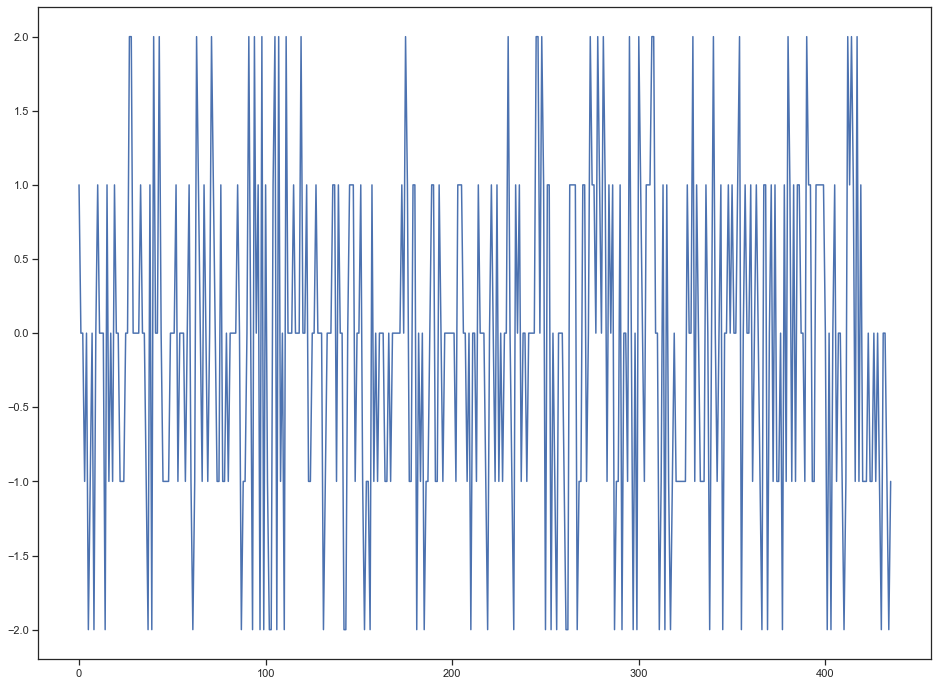

In [88]:
from matplotlib.pyplot import figure
figure(figsize=(16, 12))
plt.plot(error)

In [89]:
# XGBRegressor
regDT = XGBRegressor ()
tscv = TimeSeriesSplit(max_train_size=None, n_splits=len(X)-1)

print(tscv)
error = []
i = 0

for train_index, test_index in tscv.split(X.values):
    if len(train_index) < 20:
        continue
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    #scaller
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    #fit the model
    regDT.fit(X_train, y_train)
    y_pred = regDT.predict(X_test)
    error.append((y_test - y_pred)[0])
    i += 1

print('MSE', mean([np.power(er, 2) for er in error]))
'''
3 selected features:
MSE 0.9632173540786102

without feature selection:
0.734907178955504
'''

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=455, test_size=None)
MSE 0.734907178955504


C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\1136181293.py:25: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  print('MSE', mean([np.power(er, 2) for er in error]))


'\n3 selected features:\nMSE 0.9632173540786102'

<Figure size 1152x864 with 0 Axes>

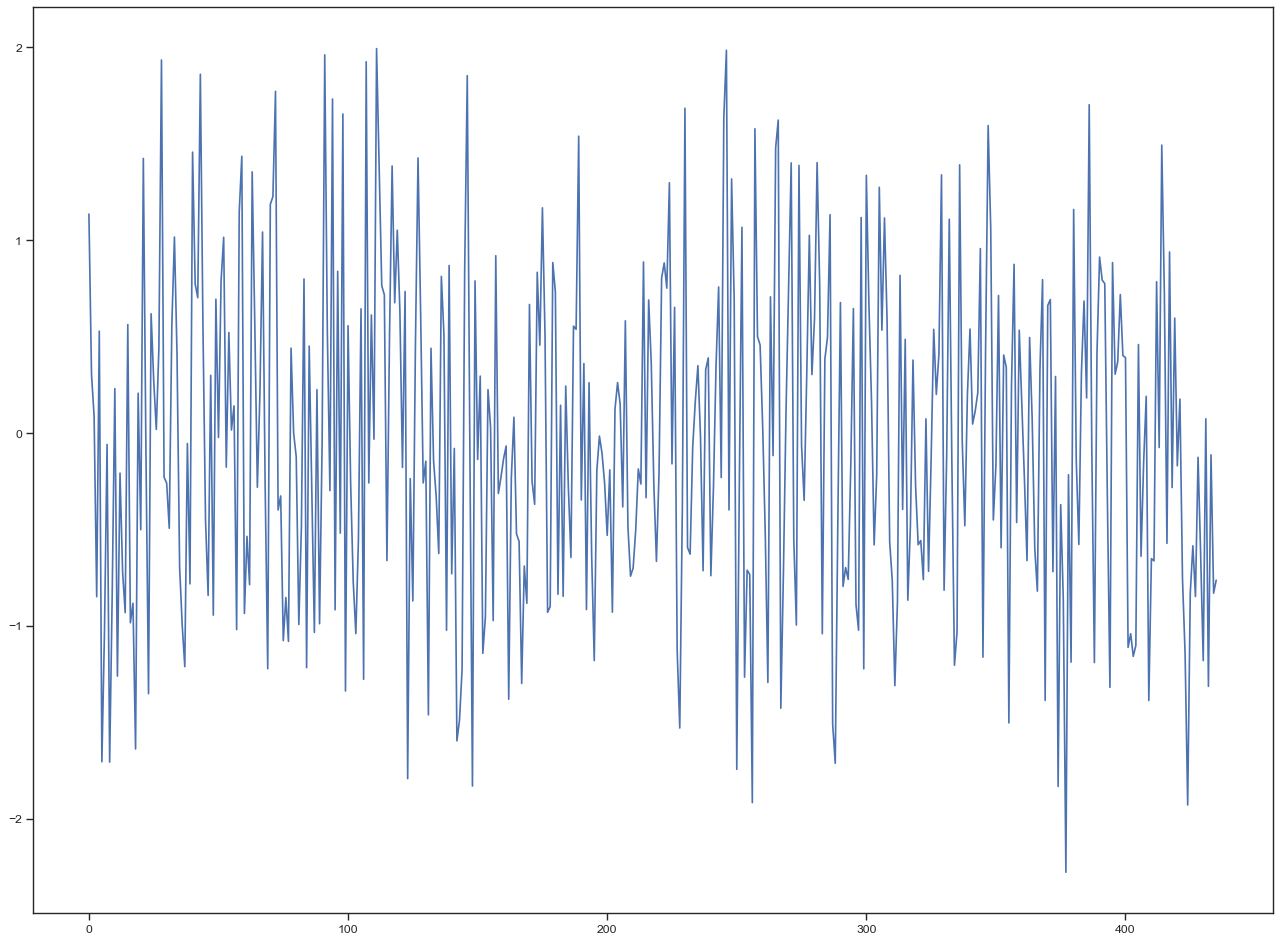

In [90]:
figure(figsize=(16, 12))
figure(figsize=(20, 15), dpi=80)
plt.plot(error)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=455, test_size=None)
MSE 0.6235628605052418


C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3130784756.py:24: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  print('MSE', mean([np.power(er, 2) for er in error]))


'\n3 selected features:\nMSE 0.6599904632187361'

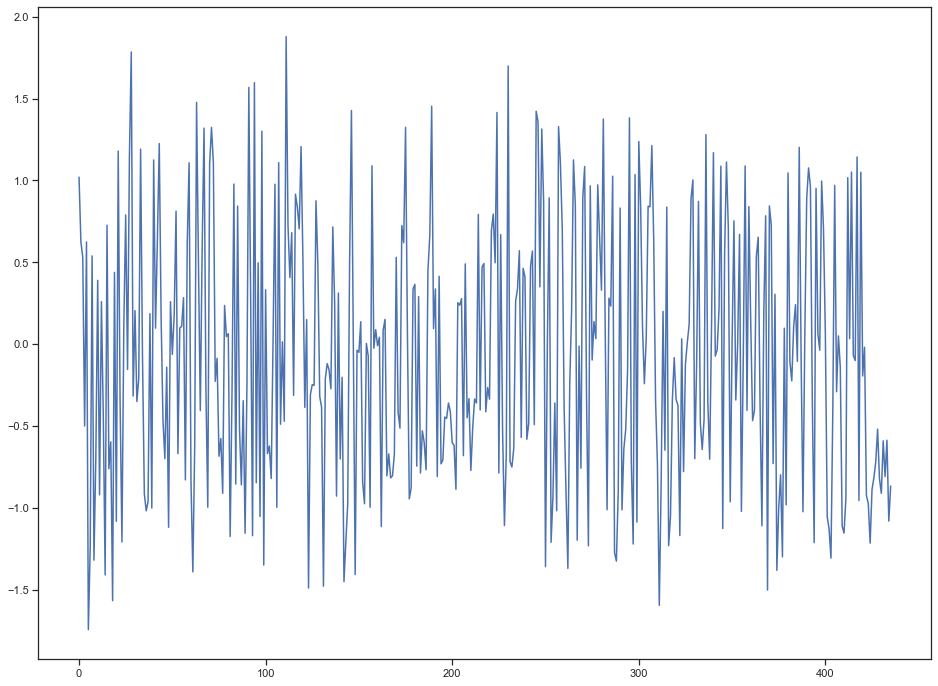

In [91]:
# XGBRegressor
regDT = XGBRFRegressor ()
tscv = TimeSeriesSplit(max_train_size=None, n_splits=len(X)-1)

print(tscv)
error = []
i = 0
for train_index, test_index in tscv.split(X.values):
    if len(train_index) < 20:
        continue
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    #scaller
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    #fit the model
    regDT.fit(X_train, y_train)
    y_pred = regDT.predict(X_test)
    error.append((y_test - y_pred)[0])
    i += 1

print('MSE', mean([np.power(er, 2) for er in error]))
figure(figsize=(16, 12))

plt.plot(error)
'''
3 selected features:
MSE 0.6599904632187361

without feature selection:
0.6235628605052418
'''

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=455, test_size=None)


C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y

C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y

C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y

C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y

C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y

C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y

C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y

C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y

C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y

C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y

C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y

C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y

C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y

C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regDT.fit(X_train, y_train)


MSE 0.6158548165137615


C:\Users\Akhod\AppData\Local\Temp\ipykernel_7964\3742317718.py:24: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  print('MSE', mean([np.power(er, 2) for er in error]))


'\n3 selected features:\nMSE 0.753716067800793'

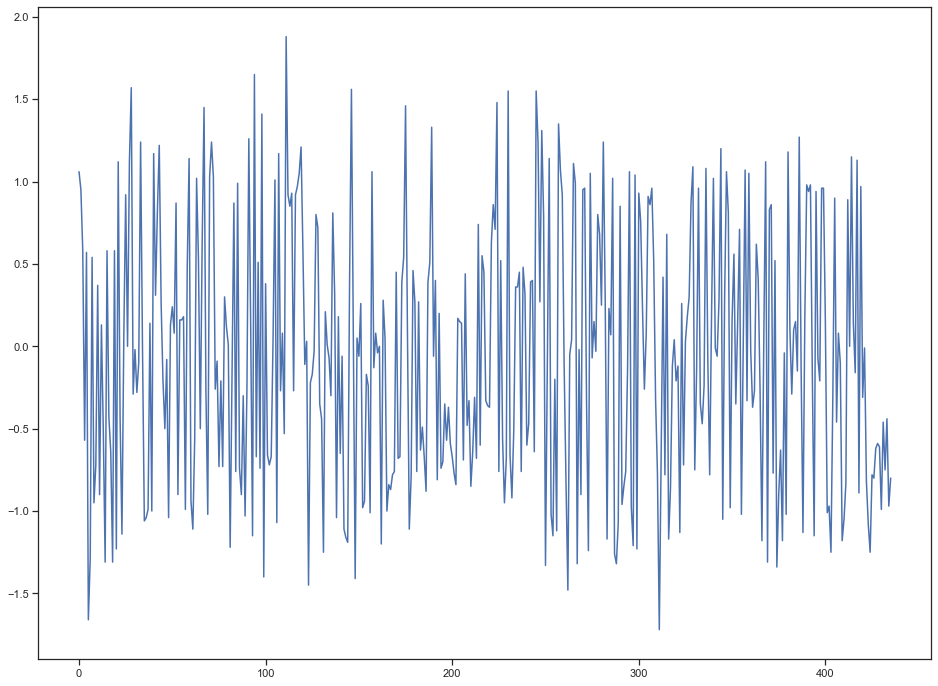

In [92]:
from sklearn.ensemble import RandomForestRegressor
regDT = RandomForestRegressor ()
tscv = TimeSeriesSplit(max_train_size=None, n_splits=len(X)-1)

print(tscv)
error = []
i = 0
for train_index, test_index in tscv.split(X.values):
    if len(train_index) < 20:
        continue
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    #scaller
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    #fit the model
    regDT.fit(X_train, y_train)
    y_pred = regDT.predict(X_test)
    error.append((y_test - y_pred)[0])
    i += 1

print('MSE', mean([np.power(er, 2) for er in error]))
figure(figsize=(16, 12))

plt.plot(error)

'''
3 selected features:
MSE 0.753716067800793

without feature selection:
0.6158548165137615
'''